# Testing navigation encoding hypotheses from rat HPC

**Authors**:

  * Author: steevelaquitaine@epfl.ch; laquitainesteeve@gmail.com.
  * Adapted from notebooks by Steffen Schneider, Jin H Lee, Mackenzie Mathis
  * Duration: 6 min

**Learning outcomes**:

  * know how to perform a more targetted <u>hypothesis-driven analyses</u>, with `CEBRA-Behavior` mode. We will qualitatively test whether both position and direction are encoded in the rat Hippocampus, by using a <u>control</u> manifold

**Readings:**

* Schneider, S., Lee, J. H., & Mathis, M. W. (2023). Learnable latent embeddings for joint behavioural and neural analysis. Nature, 617(7960), 360-368. see [Figure 2](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) in Schneider, Lee, Mathis.

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ipython-autotime # time track colab notebook cells
%load_ext autotime
!pip install --pre 'cebra[datasets,demos]'

In [ ]:
# import software packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

time: 10.4 s (started: 2024-03-14 08:03:59 +00:00)


## (1s) Loading the dataset

- The data will be automatically downloaded into a `/data` folder.

In [ ]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:01<00:00, 8.15MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'
time: 2.76 s (started: 2024-03-14 08:04:10 +00:00)


## (20s) Hypothesis-driven approach

- We will compare CEBRA-Behavior and CEBRA-Hybrid models as in the recommended [CEBRA workflow](https://cebra.ai/docs/usage.html#the-cebra-workflow).

- We use an output dimension set to 3; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

### (20s) Hypothesis: behavioral position+direction

#### (1s) Parametrize

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [ ]:
max_iterations = 100 #10000 #default is 5000.

cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 833 µs (started: 2024-03-14 08:05:36 +00:00)


#### (20s) Train the model

- We train the model <u>with neural data</u> and the <u>behavior variable</u> including position and direction.
- Train the model with 3D output that uses positional information (position + direction).
- Setting <u>conditional = 'time_delta'</u> means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.
- `hippocampus_pos.continuous_index.numpy()` contains both rat's position and direction information

In [ ]:
# train the model
cebra_behavior_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())

# save model
cebra_behavior_model.save("cebra_behavior_model.pt")

pos: -0.7792 neg:  6.4698 total:  5.6905 temperature:  1.0000: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]

time: 21.1 s (started: 2024-03-14 08:07:35 +00:00)


### (1s) Control

- We train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.

#### (1s) Parametrize

In [ ]:
cebra_behavior_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 508 µs (started: 2024-03-14 08:11:46 +00:00)


#### (20s) Train the model

- Now we train the model with shuffled behavior variable.

In [ ]:
# Shuffle the behavior variable and use it for training
hippocampus_shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())

cebra_behavior_shuffled_model.fit(hippocampus_pos.neural, hippocampus_shuffled_posdir)
cebra_behavior_shuffled_model.save("cebra_behavior_shuffled_model.pt")

pos: -0.7226 neg:  6.9163 total:  6.1937 temperature:  1.0000: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]

time: 20.4 s (started: 2024-03-14 08:11:47 +00:00)



### (1s) Get the neural manifolds

In [ ]:
# CEBRA-Behavior
cebra_behavior_model = cebra.CEBRA.load("cebra_behavior_model.pt")
cebra_behavior = cebra_behavior_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior with shuffled labels
cebra_behavior_shuffled_model = cebra.CEBRA.load("cebra_behavior_shuffled_model.pt")
cebra_behavior_shuffled = cebra_behavior_shuffled_model.transform(hippocampus_pos.neural)

time: 83.8 ms (started: 2024-03-14 08:13:39 +00:00)


### (1s) Plot

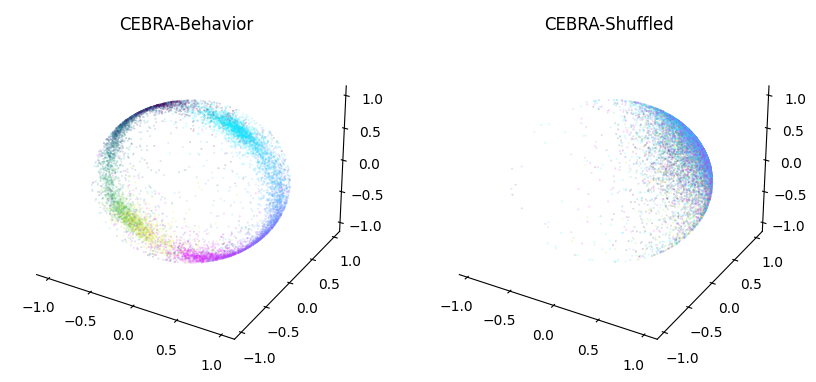

time: 1.19 s (started: 2024-03-14 08:16:03 +00:00)


In [ ]:
%matplotlib inline

right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

# setup figure
fig = plt.figure(figsize=(10,5))

# create two panels
ax1 = plt.subplot(121, projection='3d')
ax2 = plt.subplot(122, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1 = cebra.plot_embedding(ax=ax1,
                               embedding=cebra_behavior[dir,:],
                               embedding_labels=hippocampus_pos.continuous_index[dir,0],
                               title='CEBRA-Behavior',
                               cmap=cmap
                               )
    ax2 = cebra.plot_embedding(ax=ax2,
                               embedding=cebra_behavior_shuffled[dir,:],
                               embedding_labels=hippocampus_pos.continuous_index[dir,0],
                               title='CEBRA-Shuffled', cmap=cmap
                               )

plt.show()